## Import Libraries

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from PIL import Image
from datetime import datetime
import os, json, cv2, random, pathlib, shutil
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# import helper functions
import helper as h

## Define Detectron2 Dataset

In [2]:

from detectron2.data.datasets import register_coco_instances

%load_ext autoreload
%autoreload 2

prj_path = "../../google-drive/"   # root directory of Project Data
dataset_name = "stomata100" # name of the dataset    
img_dir = os.path.join(prj_path, f"{dataset_name}/images")  # get the image directory 
label_filename = os.path.join(prj_path, f"{dataset_name}/labels/labels.json")

# get annotations that is ready for detection training and drawing
"""
each dictionay consists of these indices:
 - file_name
 - image_id
 - height, 
 - width, 
 - annotations
"""
label_dicts = h.get_detectron2_dicts_raw(img_dir, label_filename) 

# random Shuffle
random.seed(28825252)
random.shuffle(label_dicts)
print("Randomly shuffle label dicts...")

# split
train_percentage = 0.8
train_num = int(len(label_dicts) * train_percentage)
print(f"set training number to {train_num} (e.g., {train_percentage*100}% of the dataset)...")

# initialise variables
label_cat = {}
img_dirs = {}
label_filenames = {}
label_cat['train'] = label_dicts[:train_num]
label_cat['val'] = label_dicts[train_num:]


#######################################
# PREPARE TRAINING AND VALIDATION SET #
#######################################

for d in ["train", "val"]:
    img_dirs[d] = os.path.join(prj_path, f"{dataset_name}/{d}")
    label_filenames[d] = os.path.join(prj_path, f"{dataset_name}/labels/labels_{d}.json")
    # reset /train folder
    shutil.rmtree(img_dirs[d])
    os.makedirs(img_dirs[d], exist_ok=True)
    # reset label_train.json
    open(label_filenames[d], 'w').close()
    with open(label_filenames[d], 'a') as f:
        f.write('[')
    # extract training and validation imgs and labels from /images and labels.json
    for idx, v in enumerate(label_cat[d]):
        # copy training set from images to /train
        dst = os.path.join(img_dirs[d], os.path.basename(v["file_name"]))
        shutil.copyfile(v["file_name"], dst)
        # save dict to label_train.json
        with open(label_filenames[d], 'a') as f:
            json.dump(v, f)
            if idx < len(label_cat[d]) - 1:
                f.write(',')
    with open(label_filenames[d], 'a') as f:
        f.write(']')
        f.close()
        

#####################
# REGISTER DATASETS #
#####################

# register training set and validation set using COCO
# Note these they can only be registered once.
# There is an interesting bug when COCO read JSON files, it should get a list[dict]
# however it asserts list[dict] with dict and return an error. Not sure how to solve it.

# register_coco_instances("train_dataset", {}, train_label_filename, train_label_filename)
# register_coco_instances("val_dataset", {}, val_label_filename, val_img_dir)

for d in ["train", "val"]:
    catelog_name = f"{dataset_name}_{d}"
    if catelog_name in DatasetCatalog:
        DatasetCatalog.remove(catelog_name)
    if catelog_name in MetadataCatalog:
        MetadataCatalog.remove(catelog_name)
    
    print("load ", label_filenames[d], " to DatasetCatalog...")
    #DatasetCatalog.register(catelog_name, lambda d=d: h.get_detectron2_dicts_raw(img_dir[d],label_filename, delta=5))
    DatasetCatalog.register(catelog_name, lambda d=d: h.get_detectron2_dicts(json_filename = label_filenames[d]))
    MetadataCatalog.get(catelog_name).set(thing_classes=["stomata"])

stomata_metadata = MetadataCatalog.get("{}_train".format(dataset_name))


Randomly shuffle label dicts...
set training number to 80 (e.g., 80.0% of the dataset)...
load  ../../google-drive/stomata100/labels/labels_train.json  to DatasetCatalog...
load  ../../google-drive/stomata100/labels/labels_val.json  to DatasetCatalog...


## Dataset visualisation

To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:

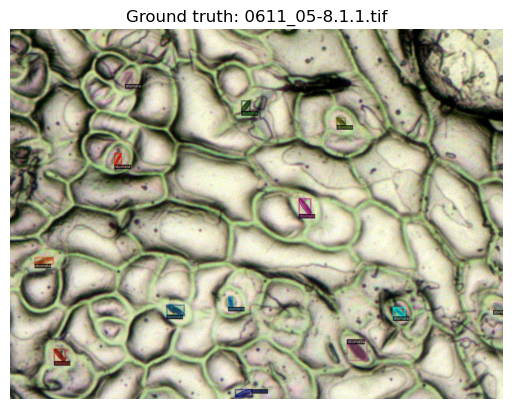

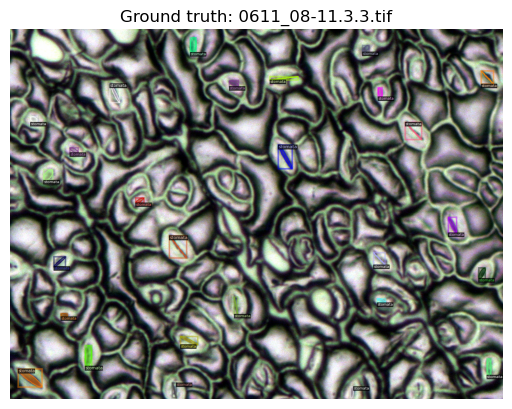

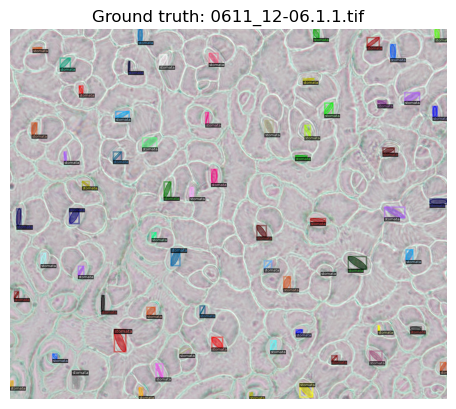

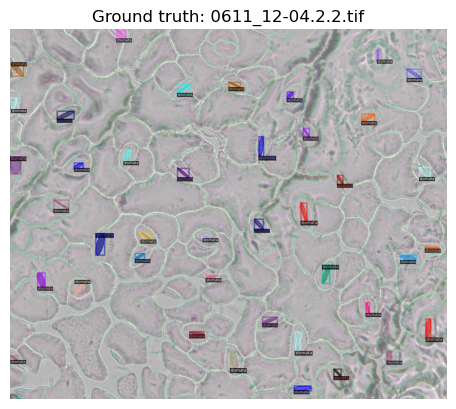

In [8]:
my_dataset_train_metadata = MetadataCatalog.get("stomata100_train")
dataset_dicts = DatasetCatalog.get("stomata100_train")

print_example = True

# Draw annotated examples from training data.
if print_example:
    num_example = 4
    for d in random.sample(dataset_dicts, num_example):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1)
        out = visualizer.draw_dataset_dict(d)
        
        plt.figure()
        plt.imshow(out.get_image())
        plt.axis('off')
        plt.title("Ground truth: {}".format(os.path.basename(d["file_name"])))

## Training
### STEP 1: Set Training Parameters

Here we use `train_net.py` to enable multi-GPU training.

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (f"{dataset_name}_train",)
cfg.DATASETS.TEST = (f"{dataset_name}_val", )
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 16000 # you may need to train longer for a practical dataset 300, 1000?
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.REFERENCE_WORLD_SIZE = 1    # REFERENCE_WORLD_SIZE * MAX_ITER = TOTAL_ITERATION

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (stomata). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE = "cuda"    # train with CUDA


now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
result_dir = f"./{dataset_name}_output_ep{int(cfg.SOLVER.MAX_ITER*cfg.SOLVER.REFERENCE_WORLD_SIZE)}_{dt_string}"
os.makedirs(result_dir, exist_ok=True)
cfg.OUTPUT_DIR= os.path.join(result_dir, "train_output")
 
#print(cfg)

### STEP 2: Start Training

In [5]:
%load_ext autoreload
%autoreload 2

from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# THIS IS FOR MLUTIPLE GPUS. DOESN'T WORK AT THE MOMENT
#!python ../tools/train_net.py --num-gpus 2  --dist-url "tcp://100.100.8.127:8989"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[02/13 22:56:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/13 22:56:39 d2.engine.train_loop]: Starting training from iteration 0


/home/pychen/anaconda3/envs/abrc/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/13 22:56:44 d2.utils.events]:  eta: 0:46:08  iter: 19  total_loss: 7.371  loss_cls: 0.6905  loss_box_reg: 0.06249  loss_mask: 0.6938  loss_rpn_cls: 4.899  loss_rpn_loc: 1.022  time: 0.1715  data_time: 0.0155  lr: 4.9953e-06  max_mem: 2334M
[02/13 22:56:48 d2.utils.events]:  eta: 0:45:21  iter: 39  total_loss: 4.312  loss_cls: 0.6715  loss_box_reg: 0.193  loss_mask: 0.693  loss_rpn_cls: 1.921  loss_rpn_loc: 0.893  time: 0.1689  data_time: 0.0053  lr: 9.9902e-06  max_mem: 2334M
[02/13 22:56:51 d2.utils.events]:  eta: 0:45:30  iter: 59  total_loss: 3.032  loss_cls: 0.6389  loss_box_reg: 0.284  loss_mask: 0.6918  loss_rpn_cls: 0.5282  loss_rpn_loc: 0.8896  time: 0.1687  data_time: 0.0053  lr: 1.4985e-05  max_mem: 2334M
[02/13 22:56:55 d2.utils.events]:  eta: 0:45:11  iter: 79  total_loss: 2.946  loss_cls: 0.6065  loss_box_reg: 0.5029  loss_mask: 0.6902  loss_rpn_cls: 0.3562  loss_rpn_loc: 0.843  time: 0.1680  data_time: 0.0052  lr: 1.998e-05  max_mem: 2334M
[02/13 22:56:58 d2.utils.eve

# Inference & evaluation using the trained model

Now, let's run inference with the trained model on the stomata validation dataset. First, let's create a predictor using the model we just trained.
Inference should use the config with parameters that are used in training
cfg now already contains everything we've set previously. We changed it a little bit for inference:

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.INPUT.MIN_SIZE_TEST = 0 # disable resize in testing
predictor = DefaultPredictor(cfg)

[02/13 23:51:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./stomata100_output_ep16000_2023_02_13_22_56_36/train_output/model_final.pth ...


In [7]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

output_dir = os.path.join(result_dir, "val_output")
os.makedirs(output_dir, exist_ok=True)

evaluator = COCOEvaluator(f"{dataset_name}_val", output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, f"{dataset_name}_val")
with open(os.path.join(output_dir, "val_output.txt"), "w") as f:
    print(inference_on_dataset(predictor.model, val_loader, evaluator),file=f)
# another equivalent way to evaluate the model is to use `trainer.test`

[02/13 23:52:03 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/13 23:52:03 d2.evaluation.coco_evaluation]: Trying to convert 'stomata100_val' to COCO format ...
[02/13 23:52:03 d2.data.datasets.coco]: Converting annotations of dataset 'stomata100_val' to COCO format ...)
[02/13 23:52:03 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/13 23:52:03 d2.data.datasets.coco]: Conversion finished, #images: 20, #annotations: 520
[02/13 23:52:03 d2.data.datasets.coco]: Caching COCO format annotations at './stomata100_output_ep16000_2023_02_13_22_56_36/val_output/stomata100_val_coco_format.json' ...
[02/13 23:52:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(0, 0), max_size=1333, sample_style='choice')]
[02/13 23:52:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/13 23:52:04 d2.data.common]: Se